**Notebook to generate two-phase linear-elastic Microstructures**

----------

The Notebook is designed to be run on Google Colab. Except for the FEniCS import, it can run locally.

Various parameters of the data sets to be created can be changed below

NECESSARY: Give a specific path to modules

----------

Credit: 

Thanks for Tim Duka for writing the code this notebook is based on. It has been somewhat adapted and optimized.

----------

# Set up

In [ ]:
# SET UP
# Insert here the path to the modules in the folder "helper_functions"
# Example: '/content/drive/myfolder/helper_functions'
PATH_TO_MODULES = './helper_functions'

In [ ]:
# Installation of FEniCS and Dolfin on Google Colab. Simplest way.
# See: https://fem-on-colab.github.io/
!wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"

from fenics import *
import fenics
from ufl import nabla_div
from ufl import nabla_grad
import numpy as np
import numpy.linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy
from scipy.stats import norm
from scipy.linalg import cholesky
import time

import h5py


from google.colab import drive
drive.mount('/content/drive')

import sys
# sys.path.append('/content/drive/MyDrive/Bachelor Thesis/models')
sys.path.append(PATH_TO_MODULES)

# Function Definitions

In [ ]:
# Functions for sample generation

def getMeshgrid(n, x_end=1, y_end=1):
    """Gives Back a nxn regular Meshgrid for the midpoints of the nxn cells in the defined area of the I quadrant"""
    dx = x_end/n
    x = np.linspace(dx/2, x_end-dx/2, n)
    y = np.linspace(dx/2, y_end-dx/2, n)
    
    mesh = np.meshgrid(x, y)
    return mesh

    
def getDistances(xx, yy):
    x_cords = xx.flatten()  # 1D array of x_cords for all nodes
    y_cords = yy.flatten()  # 1D array of y_cords for all nodes
    # Now create square matrices (i,j) holding the x/y distance of nodes i & j
    xx_cords = np.tile(x_cords, (len(x_cords), 1))
    yy_cords = np.tile(y_cords, (len(y_cords), 1))
    xx_distances = np.abs(xx_cords - xx_cords.T)
    yy_distances = np.abs(yy_cords - yy_cords.T)

    return xx_distances, yy_distances


def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(np.linalg.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3


def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = np.linalg.cholesky(B)
        return True
    except np.linalg.LinAlgError:
        return False


def createCovarianceMatrix(xx_distances, yy_distances, A_e, ar, sigma, rel_corr):
    """
    Creates the Covariance Matrix for use in a multivariate Gaussian RNG to
    create Images of blobs of 2 different phases on a 2D rectangle
    """
    lx = np.pi / (A_e * ar)
    ly = (np.pi * ar) / A_e
    d = np.log(1 / rel_corr)
    cov = (sigma ** 2) * np.exp(-d * (lx * xx_distances ** 2 + ly * yy_distances ** 2))

    eps = 1e-13
    offset = np.diag(np.repeat(eps,cov.shape[0]))

    # cov = cov * (1 - eps) + offset
    cov = cov + offset

    return cov


def createRandomValuesForImage(mean, cov):
    # approach 1: good but slow
    # ran = np.random.multivariate_normal(mean, cov)
    # approach 3
    ran = mean + np.linalg.cholesky(cov) @ np.random.standard_normal(mean.size)

    return ran


def generateImageArray(ran, n, cutoff):
    img = np.zeros(len(ran))
    img[ran > cutoff] = 1
    return img


def generate_image(n=10, sigma=1, A_ellipse=0.25, a_r=1, rel_cor=0.01, vol_frac=0.5):
    # Global Parameters:
    n = n
    sigma = sigma
    A_ellipse = A_ellipse  # Area of the ellipse
    ar = a_r  # AxisRatio of the ellipse's axes rx/ry
    rel_cor = rel_cor  # relative value of correlation along ellipse boundary
    vol_frac = vol_frac  # fraction of the volume that will be filled with phase 1 in a mean sense
    z_cutoff = 0  # cutoff value fixed
    mu = z_cutoff - sigma * norm.ppf(vol_frac)  # mean to achieve vol_frac of phase 1

    xx, yy = getMeshgrid(n)

    # start = time.process_time()
    xx_dist, yy_dist = getDistances(xx, yy)
    # print('Time for distances: ', time.process_time() - start)

    start = time.process_time()
    cov = createCovarianceMatrix(xx_dist, yy_dist, A_ellipse, ar, sigma, rel_cor)
    # print('Time for cov matrix: ', time.process_time() - start)

    mean = mu * np.ones(n ** 2)

    start = time.process_time()
    ran = createRandomValuesForImage(mean, cov)
    # print('Time for drawing from MVG: ', time.process_time() - start)

    # start = time.process_time()
    img = generateImageArray(ran, n, z_cutoff)
    # print('Time for image generation: ', time.process_time() - start)

    return ran, img

In [ ]:
# calculating the material matrix

def calculate_material_matrix(rand_vec, n=10, E_1=1., contrast_ratio=0.5, nu=0.3):
    # Variables
    rand_vec = rand_vec
    n = n
    E_1 = E_1  # E-Modul
    nu = nu  # Poisson's number
    frac = 1 / contrast_ratio
    E_2 = frac * E_1
    eps_bar = np.array([[1, 0, 0],
                        [0, 1, 0],
                        [0, 0, 1]])  # according to Miehe, 2002: eps_bar[:,x] = [ \eps_11, \eps_22, 2*\eps_12]

    # Create mesh and define function space
    mesh = UnitSquareMesh(n, n)
    # mesh = RectangleMesh(Point(0., 0.), Point(1., 100.), 3, 20)
    V = VectorFunctionSpace(mesh, 'P', 1)

    # Define boundary condition

    def boundary(x, on_boundary):
        return on_boundary

    # Define mesh function for material boundaries
    tol = 1E-12
    materials = MeshFunction('size_t', mesh, mesh.topology().dim(), 0)
    domain = rand_vec.reshape(n, n)
    materials_domain = np.zeros((n, 2 * n)).astype(int)  # since mesh is triangular one need double the entries
    for i in range(n):  # due to fenics mesh function,
        materials_domain[n - i - 1, ::2] = domain[i, :]
        materials_domain[n - i - 1, 1::2] = domain[i, :]
    materials.array()[:] = materials_domain.flatten()
    File('materials2D.xml') << materials

    class E(UserExpression):
        def __init__(self, material, e_1, e_2, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.material = material
            self.e_1 = e_1
            self.e_2 = e_2

        def eval_cell(self, values, x, cell):
            if self.material[cell.index] == 0:
                values[0] = self.e_1
            else:
                values[0] = self.e_2

        def value_shape(self):
            # return (1,)
            return ()

    # Define strain and stress
    e_mod = E(materials, E_1, E_2)

    def lambda_(E, nu):
        return (E * nu) / ((1 + nu) * (1 - 2 * nu))  # Lame's 1st parameter

    def mu(E, nu):
        return E / (2 * (1 + nu))  # Lame's 2nd parameter

    def epsilon(u):
        return 0.5 * (nabla_grad(u) + nabla_grad(u).T)
        # return sym(nabla_grad(u))

    def lambda_prime(lambd, mue):
        return 2 * lambd * mue / (lambd + 2 * mue)

    # according to https://comet-fenics.readthedocs.io/en/latest/demo/elasticity/2D_elasticity.py.html

    def sigma(u):
        return lambda_prime(lambda_(e_mod, nu), mu(e_mod, nu)) * nabla_div(u) * Identity(2) + 2 * mu(e_mod,
                                                                                                     nu) * epsilon(u)
    # Define variational problem
    u = TrialFunction(V)
    d = u.geometric_dimension()  # space dimension
    v = TestFunction(V)
    f = Constant((0, 0))
    a = fenics.inner(sigma(u), epsilon(v)) * dx
    L = dot(f, v) * dx

    # Assemble System Matrix
    A = assemble(a)
    K = A.array()

    # print("here 1")

    # dof's:
    geometrical_dim = mesh.geometry().dim()
    dof_cords = V.tabulate_dof_coordinates()  # Coordinates of all dofs in system
    vertex_cords = dof_cords[1::2, :]

    # construct boolean index vectors for boundary and inner nodes
    boundary_left = dof_cords[:, 0] < tol
    boundary_right = dof_cords[:, 0] > 1 - tol
    boundary_top = dof_cords[:, 1] > 1 - tol
    boundary_bottom = dof_cords[:, 1] < tol
    bound = boundary_left + boundary_right + boundary_top + boundary_bottom
    inner = ~bound
    

    # del boundary_left, boundary_right, boundary_bottom, boundary_top
    # del A, u, d, v, f, a, L

    # print("here 2")
    # Construct submatrices: a = inner nodes, b = boundary nodes
    #  ___________   ___     ___
    # | K_aa K_ab | |u_a| _ |f_a|
    # | K_ba K_bb | |u_b| ‾ |f_b|
    #  ‾‾‾‾‾‾‾‾‾‾‾   ‾‾‾     ‾‾‾

    K_aa = K[inner, :][:, inner]
    # print("K_aa done")
    K_ab = K[inner, :][:, bound]
    # print("K_ab done")
    K_ba = K[bound, :][:, inner]
    # print("K_ba done")
    K_bb = K[bound, :][:, bound]
    # print("K_bb done")

    
    
    # del K, vertex_cords

    # print("here 3")
    # Construct D matrix according to Miehe, 2002
    #  __________________
    # |   x_1       0    |
    # |    0       x_2   | = D_q --> D = [ D_1 D_2 ... D_M ]
    # | 0.5*x_2  0.5*x_1 |
    #  ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
    start = time.process_time()

    bound_vertex_cords = dof_cords[bound, :][0::2, :]  # Coordinates of all vertices in system, gdim dofs per vertex
    D = np.zeros((3, bound_vertex_cords.size))
    D[0, 0::2] = bound_vertex_cords[:, 0]
    D[1, 1::2] = bound_vertex_cords[:, 1]
    D[2, 0::2] = 0.5 * bound_vertex_cords[:, 1]
    D[2, 1::2] = 0.5 * bound_vertex_cords[:, 0]

    # del bound_vertex_cords

    

    # print("Set up: ", time.process_time() - start)
    start = time.process_time()
    # Calculate Displacement on boundary according to Miehe , 2002
    u_bound = D.T @ eps_bar


    # Solve for inner node displacement
    # K_aa is sparse so scipy.sparse is used
    u_a = scipy.sparse.linalg.spsolve(scipy.sparse.csc_matrix(K_aa), -K_ab @ u_bound)
    

    # Construct dof displacement vector
    u_vec = np.zeros((dof_cords.shape[0], eps_bar.shape[1]))
    u_vec[inner, :] = u_a
    u_vec[bound, :] = u_bound

    # del u_vec


    # print("First matrix mults: ", time.process_time() - start)
    start = time.process_time()

    # Calculate Nodal Forces
    f_b = K_ba @ u_a + K_bb @ u_bound
    # f_b_vec = f_b.reshape(-1, 2 * eps_bar.shape[1])
    # del u_bound
    # Calculate macroscopic stress vector according to Miehe, 2002
    sigma_bar = D @ f_b

    # Calculate tangent moduli according to Miehe, 2002
    """
    # commented out for optim
    K_bb_tilde = K_bb - K_ba @ np.linalg.inv(K_aa) @ K_ab
    C = D @ K_bb_tilde @ D.T
    """

    # Print infos for validation
    # print('Nodal Coordinates:\n', vertex_cords)
    # print('Nodal Force Vector:\n', f_b)
    # print('Sigma bar:\n', sigma_bar)
    # print('Tangent moduli:\n', C)
    # print("Second matmuls: ", time.process_time() - start)

    """
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                          key= lambda x: -x[1])[:10]:
      print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
    """

    """
    # Poisson ratio and E-mod:
    poisson = [sigma_bar[1, 0] / sigma_bar[0, 0], sigma_bar[0, 1] / sigma_bar[1, 1]]
    E_mod = [sigma_bar[0, 0] * (1 - poisson[0] ** 2), sigma_bar[1, 1] * (1 - poisson[1] ** 2)]
    if __name__ == '__main__':
        print('E-mod: ', E_mod, ', Sigma bar: ', sigma_bar)
    """
    
    return sigma_bar


if __name__ == '__main__':
    vec = np.zeros(100)
    vec[np.random.randint(0, 100, 5)] = 1
    cMatrix = calculate_material_matrix(vec, n=10, E_1=1., contrast_ratio=0.1)
    print('C matrix = ')
    print(cMatrix)


# Script to Create Data Set

**Parameters:**

```
x: data set size
n: side length of one sample
a_r: array containing possible aspect ratios
contrast_ratio: E_1/E_2
binary: True: save as binary representation, False: Save gaussian distribution

single_volume_frac, single_a_r: if true only the correpsonding value will be considered
```





In [ ]:
# generating dataset

x = 1000  # number of data points to be generated
n = 32  # number of mesh elements per coordinate axis
a_r = np.array([1/4, 1/3, 1/2, 1, 2, 3, 4])  # possible values for aspect ratio
contrast_ratio = 0.002 # E_1 / E_2, currently 500

binary = True

conv_dataset = False

single_volume_frac = False
vol_frac_value = 0.25

single_a_r = False
a_r_value = 4

images = np.zeros((x, n**2))  # stores all random sample vectors generated
c_vectors = np.zeros((x, 9))  # stores all sample effective property c matrices (vectorized)
areas_ellipse = np.zeros(x)
aspect_ratios = np.zeros(x)
volume_fractions = np.zeros(x)



start = time.process_time()
for i in range(x):
    
    if (i + 1) % max(int(x / 20),1) == 0:
        print('%3.1f percent done' % (((i + 1) / x) * 100))
    
    if single_volume_frac:
        volume_fractions[i] = vol_frac_value
    else:
        volume_fractions[i] = np.random.uniform(0.25, 0.75)

    if single_a_r:
        aspect_ratios[i] = a_r_value
    else:
        aspect_ratios[i] = a_r[np.random.randint(0, a_r.shape[0])]

    areas_ellipse[i] = np.random.uniform(0.1, 0.9)
    start_img_gen = time.process_time()
    random, img = generate_image(n=n, sigma=1, A_ellipse=areas_ellipse[i], a_r=aspect_ratios[i], rel_cor=0.01,
                                          vol_frac=volume_fractions[i])
    
    # random = images[i,:]
    
    # print("Image generation: ", time.process_time() - start_img_gen)

    if binary:
        images[i, :] = img
  
    # always pass binary data to FEM, but register correlation or binary in database
    # pass img for binary calculation, pass images[i, :] for correlation calculation
    c_vectors[i, :] = calculate_material_matrix(img, n=n, E_1=1., contrast_ratio=contrast_ratio, nu=0.3).flatten()


delta_t = time.process_time() - start
print("Elapsed time", delta_t)

name_str = 'n=%d_x=%d' % (n, x)

name_str = name_str + "_cr=" + "{:.4f}".format(contrast_ratio)

if single_volume_frac:
  name_str = name_str + ('_vol_frac%.2f' % vol_frac_value)
else:
  name_str = name_str + '_all_vol_fracs'

if single_a_r:
  name_str = name_str + ('_ar%.2f' % a_r_value)
else:
  name_str = name_str + '_all_ar'

if binary:
  name_str = name_str + '_binary'

name_str = name_str + '.h5'


hf = h5py.File(name_str, 'w')

hf.create_dataset('volume_fractions', data=volume_fractions)
hf.create_dataset('areas_ellipse', data=areas_ellipse)
hf.create_dataset('aspect_ratios', data=aspect_ratios)
hf.create_dataset('contrast_ratio', data=contrast_ratio)
hf.create_dataset('images', data=images)
hf.create_dataset('c_vectors', data=c_vectors)
hf.close()

# Print some information
print('Generated Data Set:')
print('Mean volume fraction: ', np.mean(volume_fractions), ', should be 0.5')
print('Mean ellipse area: ', np.mean(areas_ellipse), ', should be 0.5')
print('Mean aspect ratio: ', np.mean(aspect_ratios), ', should be', np.mean(a_r))

# plot some
number_of_images = x
rands = np.random.randint(0, number_of_images, 25)
training_data = images[rands, :]
training_targets = c_vectors[rands, 1]
vmin = np.min(training_data.flatten())
vmax = np.max(training_data.flatten())
v = max(np.abs(vmin), np.abs(vmax))


for i in range(25):
    plt.subplot(5, 10, 2 * i + 1)
    continuous_image_i = training_data[i, :].reshape(n, n)
    discrete_image_i = np.zeros((n, n))
    discrete_image_i[continuous_image_i > 0] = 1
    plt.imshow(continuous_image_i, vmin=-v, vmax=v)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.subplot(5, 10, 2 * (i + 1))
    plt.imshow(discrete_image_i)
    plt.xticks([])
    plt.yticks([])
    plt.title(
        'A=%.2f, a_r=%.2f, Vol=%.2f' % (areas_ellipse[rands[i]], aspect_ratios[rands[i]], volume_fractions[rands[i]]))

# print("Total time:", time.process_time() - start)

# Example image saving

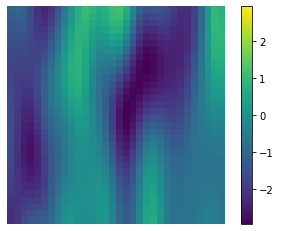

In [ ]:
plt.figure(0)

vmin = np.min(random.flatten())
vmax = np.max(random.flatten())
v = max(np.abs(vmin), np.abs(vmax))

plt.imshow(random.reshape((32,32)), vmin=-v, vmax=v)
#plt.imshow(img.reshape((32,32)))
plt.axis('off')
plt.colorbar()
plt.savefig("./example_random", bbox_inches='tight', pad_inches=0)